In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import os
import decoupler as dc
import seaborn as sns
plt.rcParams.update({'font.size': 11})

In [2]:
data_path = '../Data/robustness_fig4/'

In [3]:
runs = os.listdir(data_path)

# if =='original' then insert at 0
for run in runs:
    if run == 'original':
        runs.insert(0, runs.pop(runs.index(run)))

In [4]:
factor_scores = []
lr_loadings = {}

W_matrices = []  # Store W matrices from each run
H_matrices = []  # Store H matrices
feature_indices = []  # Store feature indices

for run in runs:
    fs = pd.read_csv(data_path + run + '/factor_scores_fig4.csv', index_col='index').drop('Unnamed: 0', axis=1)
    W_matrices.append(fs.values)
    fs['run'] = run
    factor_scores.append(fs)
    
    lr = pd.read_csv(data_path + run + '/lr_loadings_fig4.csv', index_col='index')
    H_matrices.append(lr.values.T)
    lr['run'] = run
    lr_loadings[run] = lr
    feature_indices.append(lr.index)

In [5]:
# original run indices
idx = feature_indices[0]

index_df = pd.DataFrame(columns=['Run', 'idx1', 'idx2'])
for i in range(0, len(runs)):
    idx2 = feature_indices[i]
    common = idx.intersection(idx2)
    index_df.loc[i] = [runs[i],
                       np.where(idx.isin(common))[0],
                       np.where(idx2.isin(common))[0]]

Re-order Corresponding Factors

In [6]:
W_matrices[0].shape

(8784, 3)

In [7]:
# Assume W_matrices contains all factor loading matrices from different runs
num_runs = len(W_matrices)
mappings = {}
df_list = []

for i in range(1, num_runs):
    mappings_run = {}
    results = []
    for j in range(W_matrices[0].shape[1]):
        max_similarity = -np.inf
        best_match = None
        for k in range(W_matrices[i].shape[1]):
            similarity, pval = pearsonr(W_matrices[0][:, j], W_matrices[i][:, k])
            results.append({'Run': runs[i],
                            'Factor_o': f'Factor{j+1}',
                            'Factor_x': f'Factor{k+1}',
                            'Correlation': similarity,
                            'Pvalue': pval})
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = k
        mappings_run[f'Factor{j+1}'] = f'Factor{best_match+1}'
    mappings[runs[i]]= mappings_run
    df_list.append(pd.DataFrame(results))

score_correlations = pd.concat(df_list, ignore_index=True)
score_correlations['fdr'] = dc.p_adjust_fdr(score_correlations['Pvalue'])
# remove cutoff
score_correlations['Run'] = score_correlations['Run'].str.replace('cutoff', '').astype(int)
score_correlations = score_correlations.sort_values(by='Run')
score_correlations.head()

,Run,Factor_o,Factor_x,Correlation,Pvalue,fdr
136,0,Factor1,Factor2,0.253591,5.872167e-129,7.239658e-129
138,0,Factor2,Factor1,0.962885,0.000000e+00,0.000000e+00
139,0,Factor2,Factor2,-0.497187,0.000000e+00,0.000000e+00
140,0,Factor2,Factor3,-0.193128,1.429323e-74,1.628342e-74
141,0,Factor3,Factor1,-0.390013,4.753258e-317,8.642288e-317


In [8]:
# Pivot the DataFrame for each 'Run'
pivot_data = score_correlations.pivot_table(index="Factor_o", columns=["Run", "Factor_x"], values="Correlation")
pivot_data = pivot_data.T

In [9]:
# Create unique colors for each run
_runs = score_correlations['Run'].unique()
num_runs = len(_runs)
half_runs = num_runs // 2

# Generate colors from two different palettes
colors1 = sns.color_palette("dark", half_runs)
colors2 = sns.color_palette("husl", num_runs - half_runs)
assert len(colors1) + len(colors2) == num_runs

# Assign colors to runs
run_colors = dict(zip(_runs[:half_runs], colors1))
run_colors.update(dict(zip(_runs[half_runs:], colors2)))

/tmp/ipykernel_65963/1708606016.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


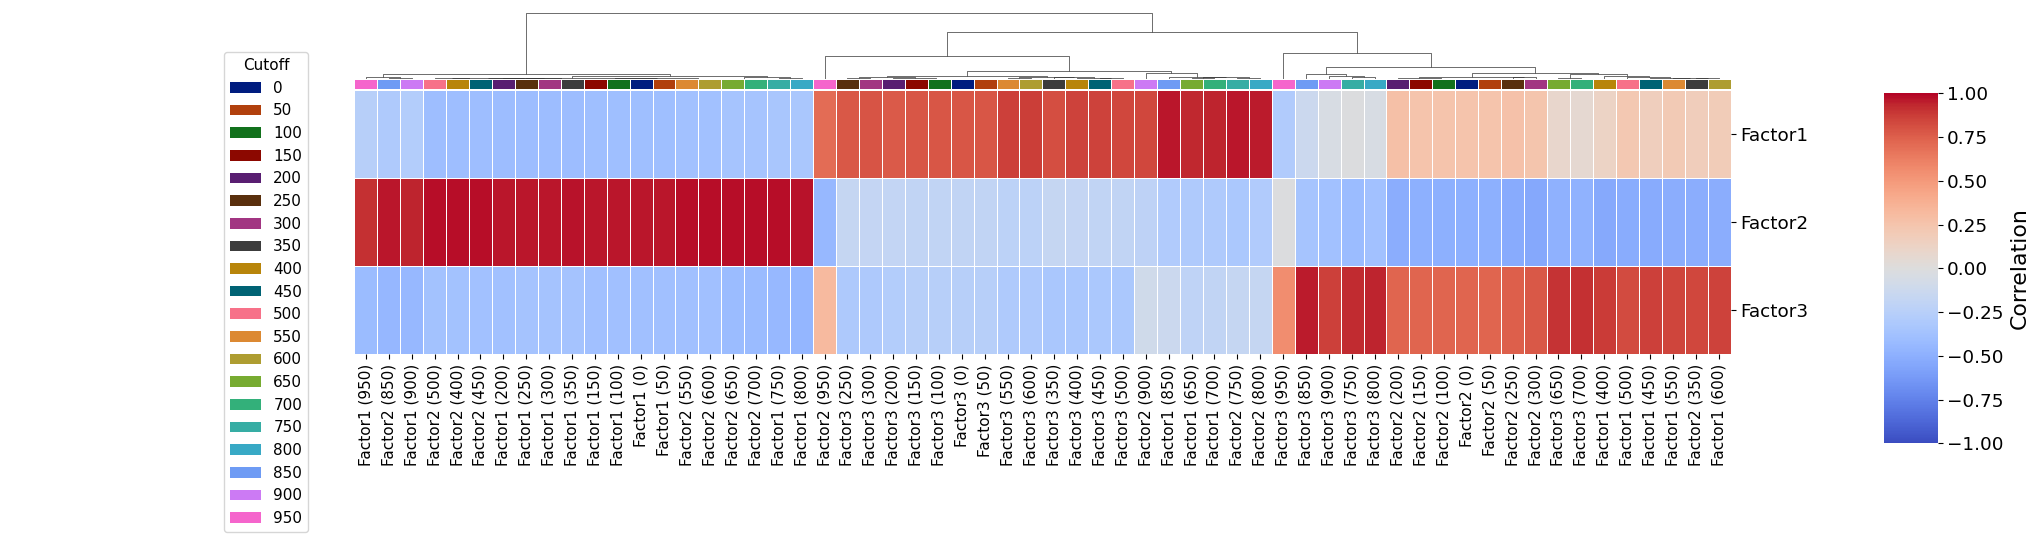

In [10]:
# Create the heatmap
ax = sns.clustermap(pivot_data.T,
                    cmap="coolwarm", cbar_kws={'label': 'Correlation'}, linewidths=.5,
                    col_colors=[run_colors[run] for run in pivot_data.index.get_level_values(0)],
                    col_cluster=True, 
                    row_cluster=False, 
                    cbar_pos=(1.05, 0.1, 0.03, 0.70),
                    vmin=-1,
                    vmax=1,
                    row_colors=None,
                    figsize=(18, 5)
                    )

for run in _runs:
    ax.ax_col_dendrogram.bar(0, 0, color=run_colors[run], label=run, linewidth=0)
    ax.ax_col_dendrogram.legend(title='Cutoff', 
                                loc='upper left',
                                bbox_to_anchor=(-0.1, 0.5), 
                                title_fontsize='medium',
                                fontsize='medium',
                                )

# cbar large font
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize='large')
cbar.set_label('Correlation', fontsize='x-large')

ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0, fontsize='large')

# get the x labels and refromat them
xticks = ax.ax_heatmap.get_xticklabels()
new_xticks = []
for x in xticks:
    xt = x.get_text().split('-')
    xt = f'{xt[1]} ({xt[0]})'
    x.set_text(xt)
xticks = ax.ax_heatmap.set_xticklabels(xticks)

# Remove x and y labels
ax.ax_heatmap.set_xlabel('')
ax.ax_heatmap.set_ylabel('')
plt.tight_layout()
plt.show()

Correlate Features of Best Mapped Factors

In [11]:
correlation_loadings = pd.DataFrame(columns=['Run', 'Factor', 'Correlation', 'P-value'])
for run in runs[1:]:
    remap = mappings[run]
    H1 = lr_loadings['original'].copy()
    H2 = lr_loadings[run].copy()
    # subset to common indices
    common = H1.index.intersection(H2.index)
    H1 = H1.loc[common]
    H2 = H2.loc[common]
    for key, value in remap.items():
        corr, pval = pearsonr(H1[key], H2[value])
        correlation_loadings.loc[len(correlation_loadings)] = [run, key, corr, pval]
        
correlation_loadings['Run'] = correlation_loadings['Run'].str.replace('cutoff', '').astype(int)
correlation_loadings = correlation_loadings.sort_values(by='Run')
correlation_loadings.head()

,Run,Factor,Correlation,P-value
47,0,Factor3,0.849966,2.194715e-113
46,0,Factor2,0.992383,0.000000e+00
45,0,Factor1,0.931965,2.381471e-178
23,50,Factor3,0.849966,2.194715e-113
21,50,Factor1,0.931965,2.381471e-178


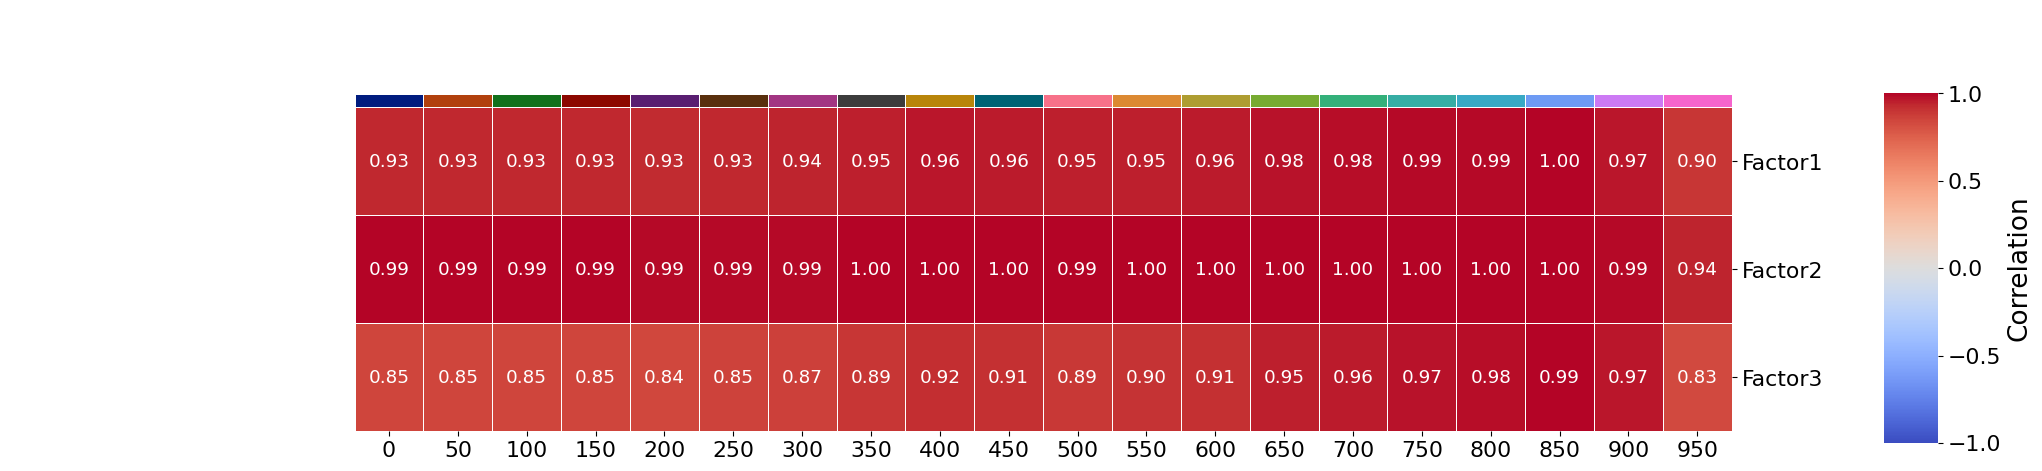

In [12]:
# Create a pivot table for the heatmap
pivot_table = correlation_loadings.pivot(index='Factor', columns='Run', values='Correlation')

ax = sns.clustermap(pivot_table, 
                    cmap='coolwarm',
                    annot=True, 
                    fmt=".2f",
                    col_colors=[run_colors[run] for run in _runs],
                    vmin=-1,
                    vmax=1,
                    row_cluster=False,
                    col_cluster=False,
                    cbar_pos=(1.05, 0.1, 0.03, 0.70),
                    figsize=(18, 5),
                    linewidths=.5
                    )

# cbar large font
cbar = ax.ax_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize='x-large')
cbar.set_label('Correlation', fontsize='xx-large')

# add legend for colors
for run in _runs:
    ax.ax_col_dendrogram.bar(0, 0, color=run_colors[run], label=run, linewidth=0)
    
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0, fontsize='x-large')
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xticklabels(), rotation=0, fontsize='x-large')

# larger annotation labels
for text in ax.ax_heatmap.texts:
    text.set_fontsize('large')

# Remove x and y labels
ax.ax_heatmap.set_xlabel('')
ax.ax_heatmap.set_ylabel('')
plt.show()

Enrichment

In [13]:
net = lr_loadings['original'].sort_values(by='Factor1', ascending=False).head(20).reset_index()[['index','Factor1']].rename(columns={'index':'target', 'Factor1':'weight'})
net['source'] = 'top'

In [19]:
ora = []
for run in runs:
    if run == 'original':
        continue
    mat = lr_loadings[run].drop('run',axis=1).T
    mat.columns.name = None
    if net['target'].isin(mat.columns).sum() > 5:
        est, pvals = dc.run_ora(mat=mat,
                                net=net,
                                n_background=mat.shape[1])
        est = est.rename(columns={'top':'-log10(pval)'})
        pvals = pvals.rename(columns={'top':'pval'})
        scores = est.merge(pvals, left_index=True, right_index=True)
        scores['run'] = run
        ora.append(scores)
ora = pd.concat(ora)
# ora['run'] = ora['run'].str.replace('cutoff', '').astype(int)
# NOTE: some bug with ora, and sets the sample names to source
ora = ora.reset_index().rename(columns={'index':'Factor'})
ora = ora.sort_values(by='run')
ora['fdr'] = dc.p_adjust_fdr(ora['pval'])

Text(0.5, -8.277777777777782, 'Cutoff')

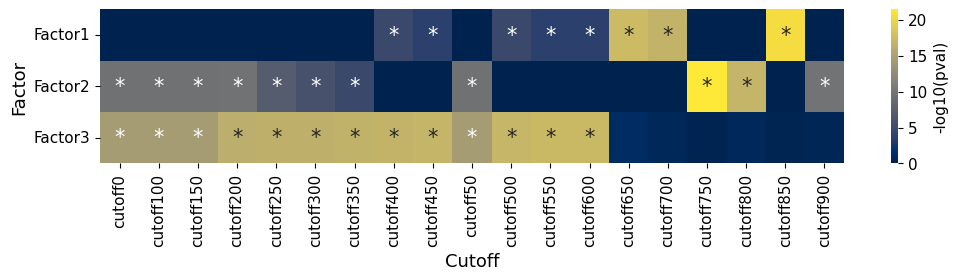

In [20]:
# heatmap
import seaborn as sns
plt.figure(figsize=(12, 2))
pivot_table = ora.pivot(index='Factor', columns='run', values='-log10(pval)')
pivot_pvals = ora.pivot(index='Factor', columns='run', values='fdr')
# pvals as asterisks
pivot_pvals = pivot_pvals.applymap(lambda x: '*' if x < 0.05 else '')
sns.heatmap(pivot_table, cmap='cividis', annot=pivot_pvals, cbar_kws={'label': '-log10(pval)'}, fmt='s', annot_kws={'size': 15})
# don't rotate y title
plt.yticks(rotation=0)
plt.ylabel('Factor', size=13)
plt.xlabel('Cutoff', size=13)